# Debiasing Word Embeddings

### What are Word Embeddings?

Word Embeddings are the result of applying dimensionality reduction techniques to words!

They give us dense representations of words, which we hope capture some syntactic and semantic information of the words. These dense representations are a natural tool for us to use if we want to pass words into neural models, and the field of Natural Language Processing (NLP) has used some variants of Word Embeddings extensively.

There are many, many, many ways to build word embeddings, but the key intuition comes from the notion that the meaning of a word can by inferred from the types of words it appears next to, or as put by John Firth in 1975: "You shall know a word by the company it keeps".

Typically, we start with a large corpora of text. We'll use this copora to give us counts of words which occur next to each other, which is a pretty good start. In this matrix, our rows correspond to an "embedding" of sorts, where each word's embedding is a word by word count of the words that appear next to it.

It's a hyperparameter, to choose how large of a window you use when considering words "next to each other", or if you want to do clever things, like weight each word by how distant it is from the word you're looking at.

Here's what a word co-occurence matrix looks like:
<img src="./figs/word-co-occurrence.png" alt="Drawing" style="width: 600px;"/>
<span style="font-size:9pt">source:http://web.stanford.edu/class/cs224u/materials/cs224u-vsm-overview.pdf</span>

Each row now captures _something_ about the word it represents, in that words that appear in similar contexts will be closer together. Of course, they might not actually be _that_ close together, since our space is the size of our vocabulary.

How big is our Vocabulary? Well, that's another hyperparameter. You can decide to filter out words that don't occur that often, to potentially get rid of noise, etc. But generally, it's going to be close to 300K or 400K. That means our word vectors are of dimension 400,000! Luckily, we can use dimensionality reduction techniques, like the ones you've seen already, to learn a low dimensional representation of this co-occurrence matrix. This will give us low-dimensional (200-300d), dense word vectors to use, so we can operate over them efficiently and pass them into models such as neural networks!

Which dimensionality reduction technique should we use? Should we normalize counts? Convert them to probability distributions and minimize things like KL divergence? These are all design choices which can have a big effect on the quality and output of your word vectors.

For this assignment, though, we'll be using a very standard set of Word Embeddings, called GloVe (Global Vectors for Word Representations https://nlp.stanford.edu/projects/glove/) These word embeddings were standard in state of the art english NLP models, until very recently.

Let's load them up and take a look at them.

In [1]:
import numpy as np
from numpy.linalg import norm

In [2]:
def load_vecs(path):
    """ Loads in word vectors from path.
    Will return a dictionary of word to index, and a matrix of vectors (each word is a row)
    """
    vecs = []
    w2i = {}
    
    with open(path, 'r') as inp:
        for line in inp.readlines():
            line = line.strip().split()
            word = str(line[0])
            w2i[word] = len(vecs)
            vecs.append(np.array(line[1:], dtype=float))
        vecs = np.array([v / norm(v) for v in vecs])
        print(f'Read in {vecs.shape[0]} words of size {vecs.shape[1]}')
    return w2i, vecs

In [3]:
# This might take a little bit to run!
from google.colab import drive 
drive.mount('/content/gdrive',force_remount=True) 


Mounted at /content/gdrive


In [4]:
indxr, wembs = load_vecs('/content/gdrive/MyDrive/glove.6B.300d.txt')
indxr_gn, wembs_gn = load_vecs('/content/gdrive/MyDrive/gn-glove1b.300d.txt')

Read in 400000 words of size 300
Read in 142527 words of size 300


In [5]:
def similarity(v1, v2):
    return np.dot(v1, v2) / (norm(v1) * norm(v2))

### TODO: Implement below!

def analogy(n, word1, word2, word3):
    """word1 is to word3 as word2 is to... top n results"""
    i2w = {v:k for k, v in indxr.items()}
    vector = wembs[indxr[word2]] - wembs[indxr[word1]] + wembs[indxr[word3]]
    remove = [indxr[word2], indxr[word1], indxr[word3]]
    # @ is Matrix multiplication 
    distance = np.array(wembs) @ vector
    index = distance.argsort()[-n-3:]
    index = np.array([dis for dis in index if dis not in remove ])
    index = np.flipud(index[-n:])
    vectors = [wembs[ind] for ind in index]
    words = [i2w[ind] for ind in index]
    return words


#   return vectors


We are going to use the cell above to help us evaluate your function.

However, you should be curious about this "analogy" function! Play around with it in the cell below. Try different words! (Remember that we have a limited vocabulary... You don't need to handle OOV words nicely, but know that your code can crash occasionally if you pass in a word that's not in our vocabulary!)

In [7]:
### TODO: Implement below!
# e.g. print(analogy(10, "man", "boy", "woman"))
print(analogy(10, "man", "boy", "woman"))
print(analogy(10, "eat", "food", "drink"))

['girl', 'girls', 'mother', 'child', 'daughter', 'pregnant', 'teenage', 'grandmother', 'baby', 'teenager']
['drinks', 'beverage', 'beverages', 'drinking', 'beer', 'bottled', 'liquor', 'alcohol', 'products', 'water']


### (Gender) Bias in Word Embeddings

Word embeddings are a very useful tool in NLP, and they have often helped researchers boost their performance in a variety of tasks. However, recently a large problem has been discovered in these types of word embeddings. They inherit some biases from the data they are trained on which is very harmful, such as mysoginistic or racist stereotypes. This is a **huge** problem, because models which use these embeddings are being deployed into the real word to assist with automation strategies!

Let's take a look at some examples of gender bias in our word embeddings, which we'll be focusing on for the rest of this assignment.

<p style='color:red'> Do not change the below cell! Make sure you run it as is before turning in your notebook.</p>

In [8]:
print(analogy(10, "man", "woman", "programmer"))
print(analogy(10, "man", "woman", "doctor"))
# Even names contain these biases!
print(analogy(10, "john", "mary", "doctor"))

['programmers', 'freelance', 'educator', 'businesswoman', 'designer', 'translator', 'technician', 'computer', 'animator', 'homemaker']
['physician', 'nurse', 'doctors', 'pregnant', 'dentist', 'medical', 'pharmacist', 'surgeon', 'nurses', 'physicians']
['nurse', 'mother', 'woman', 'doctors', 'hospital', 'pregnant', 'physician', 'dentist', 'she', 'sister']


What does it look like if we swap the analogy around?

<p style='color:red'> Do not change the below cell! Make sure you run it as is before turning in your notebook.</p>

In [9]:
print(analogy(10, "woman", "man", "programmer"))
print(analogy(10, "woman", "man", "doctor"))
print(analogy(10, "mary", "john", "doctor"))

['programmers', 'computer', 'software', 'engineer', 'developer', 'animator', 'creator', 'hacker', 'user', 'programming']
['physician', 'dr.', 'he', 'brother', 'mr.', 'himself', 'him', 'his', 'medical', 'doctors']
['physician', 'surgeon', 'doctors', 'medical', 'he', 'dr.', 'man', 'who', 'his', 'himself']


This is obviously problematic. Yet, these word embeddings (the ones you're using right now) **have been used in multiple state of the art systems in NLP!**
This is a hot area of research right now, because this poses a huge potential problem as more and more AI systems are starting to be deployed into the real world.

We're going to take a look at one method of _debiasing_ these word embeddings, which attempts to _remove gender stereotypes_ while keeping in useful gender information such as "king and queen" and "boy and girl".
The debiasing method we're going to look at is described in [this paper](https://arxiv.org/abs/1607.06520), which is one of the seminal papers on exposing stereotypes and bias in this form.

While they use different word embeddings, we've seen that our GloVe embeddings contain similar biases. Their method behaves as follows.

They first define a "gender subspace" $\mathcal{B} = (b_1, b_2, ..., b_k)$ composed of _orthogonal vectors_.
$k$ is a hyperparameter we choose.

$\mathcal{B}$ is built from a set of pairs of gendered items. The idea here is that $\mathcal{B}$ captures some notion of the "direction" of gender which we're trying to capture.

The set of pairs, $S = p_1, p_2, ..., p_n$, is given to you.
Each pair contains two words which are considered gendered words whose relation captures some notion of gender, i.e. $S = ${("woman", "man"), ("she", "he")...}

Building $\mathcal{B}$ goes as follows:


1. Build up matrix $\mathbf{C} := \sum_{i=1}^n (\vec{w_1} - \vec{w_2})(\vec{w_1} - \vec{w_2})^T + (\vec{w_2} - \vec{w_1})(\vec{w_2} - \vec{w_1})^T$, for $(w_1, w_2) \in p_i$.

That is, for each pair, subtract each word vector from the other and take the outer product of each resulting vector and add it to $\mathbf{C}$.
In our case, $\mathbf{C}$'s dimensionality should be 100 by 100.

2. Compute the SVD of $\mathbf{C}$.

You can use numpy's ```numpy.linalg.svd``` method for this.

3. This will give you a decomposition $\mathbf{U}\mathbf{\Sigma}\mathbf{V} = \mathbf{C}$. Take the top-$k$ vectors from the decomposition of $\mathbf{C}$ as the orthogonal vectors defining the space $\mathcal{B} = (b_1, ..., b_k)$. That is, you should take the first $k$ columns of $\mathbf{U}$.

Again, the intuition here is that we now have some set of vectors which, together, capture some notion of the direction of gender.

In [16]:
# Copy biased embeddings into a new object.
debiased_wembs = np.copy(wembs)

In [102]:
from numpy.linalg import svd
gender_pairs = [('she', 'he'), ('her', 'his'), ('woman', 'man'), ('mary', 'john'), ('herself', 'himself'), ('daughter', 'son'), ('mother', 'father'), ('gal', 'guy'), ('girl', 'boy'), ('female', 'male')]

### TODO: Implement below!

def build_gender_subspace(k):
    """ Build up the gender subspace. 
    The output should be the top set of k vectors from the 
    SVD decomposition of the C matrix, as defined above.
    (numpy svd returns 3 items, the first of which is U.
    You should take the first k columns of this matrix)
    """
    dim = wembs[0].shape[0]
    C = np.zeros((dim, dim))
    for pair in gender_pairs:
        v1 = wembs[indxr[pair[0]]]
        v2 = wembs[indxr[pair[1]]]
        d1 = v1 - v2
        d2 = v2 - v1
        C += np.outer(d1, d1) + np.outer(d2, d2)
    u, s, vh = np.linalg.svd(C, full_matrices=True)
    return u[:,:k]

Now let's build the subspace with $k=10$. You can check that things seem ok by making sure that the dot product between all your $b_i$ vectors is close to zero, since they should be orthogonal.

In [103]:
B = build_gender_subspace(10)

We'll only implement the neutralize" portion of the hard-debiasing method in the paper, if you're following along.
We won't implement equalize or the Soft-Debiasing method, to keep things short :)

Once we have our gender subspace $\mathcal{B}$ composed of our $k$ orthogonal vectors, we can select some choice word $w$ to debias as follows:

1. Select the embedding $\vec{w}$ of word $w$ from our regular, biased embeddings.

2. Compute $$\vec{w_\mathcal{B}} = \sum_{j=i}^k (\vec{w} \cdot \vec{b_j}) * \vec{b_j}$$.

3. Compute the new, debiased embedding as $$\vec{w_{ub}} = (\vec{w} - \vec{w_{\mathcal{B}}}) \; / \; || \vec{w} - \vec{w_{\mathcal{B}}} || $$

Intuitively, what we are doing is projecting our biased vector $\vec{w}$ into our gender subspace, and then subtracting the result from $\vec{w}$.

You should implement a function ```debias_word(word)```, which takes one argument: the word to debias. It should use our previously defined subspace ```B``` to compute $\vec{w_{ub}}$, and you should store the result in the new ```debiased_wembs``` matrix defined above, **in the same index that the word is in the original ```wemb``` matrix**.

That is, please do not change the ```wembs``` matrix directly, but save your debiased embeddings in the copy we created.

In [104]:
# debias function 
def debias_word(word):
    dim = wembs[0].shape[0]
    vector = wembs[indxr[word]]
    wB = np.zeros(dim)
    for i in range(B.shape[1]):
        wB += np.dot(vector, B[:,i]) * B[:,i]
    wub = (vector - wB)/(np.linalg.norm(vector - wB))
    debiased_wembs[indxr[word]] = wub

In [105]:
# Calculate the debiased dataset 
for word in indxr:
  debias_word(word)

In [106]:
def read_gender_list(filename1, filename2, filename3):
    female_list = []
    male_list = []
    gender_neutral_list = []

    with open(filename1, 'r') as f1:
      for line in f1:
        female_list.append(line.strip())

    with open(filename2, 'r') as f2:
      for line in f2:
        male_list.append(line.strip())

    with open(filename3, 'r') as f3:
      for line in f3:
        gender_neutral_list.append(line.strip())
    
    return female_list, male_list, gender_neutral_list


In [107]:
# get different lists 
female_list, male_list, gender_neutral_list = read_gender_list('/content/gdrive/MyDrive/female_word_file.txt','/content/gdrive/MyDrive/male_word_file.txt', '/content/gdrive/MyDrive/gender_neutral.txt') 
print("Female list has the length of", len(female_list))
print("Male list has the length of", len(male_list))
print("Gender neutral list has the length of", len(gender_neutral_list))

Female list has the length of 222
Male list has the length of 222
Gender neutral list has the length of 150


In [108]:
# Clean the input data
gender_list = []

for element in female_list:
  if element in indxr and element in indxr_gn:
    gender_list.append(element)

for element in male_list:
  if element in indxr and element in indxr_gn:
    gender_list.append(element)

for element in gender_neutral_list:
  if element not in indxr or element not in indxr_gn:
    gender_neutral_list.remove(element)

print(len(gender_list))
print(len(gender_neutral_list))

351
149


In [109]:
def compute_similarity(gender_list, gender_neutral_list, indxr, wembs):
  result = {}
  for element in gender_neutral_list:
    total = 0 
    count = 0
    element_emb = wembs[indxr[element]] 

    for target in gender_list:
      target_emb = wembs[indxr[target]]
      total += similarity(element_emb,target_emb)
      count += 1
    
    average_simliarity = total / count 
    result[element] = average_simliarity
  return result 

In [110]:
result = compute_similarity(gender_list, gender_neutral_list, indxr, wembs)
print(result)

{'advisors': -0.017638905430534233, 'attorney': 0.02989479490095007, 'retailer': -0.004847755246976582, 'professor': 0.04064898877016027, 'colleagues': 0.06543619156620575, 'advisor': 0.01562557455406406, 'co-host': 0.030610328457643284, 'barber': 0.06176488219229658, 'teachers': 0.06660149546563147, 'teacher': 0.11815133507810259, 'expert': -0.0020193594250522873, 'maker': -0.0011279128929816491, 'workers': 0.021473632954043753, 'worker': 0.07398994862108474, 'employee': 0.04961048289079744, 'employees': 0.019839489742394904, 'employer': 0.05602225868642091, 'employers': 0.016327619111896462, 'rapper': 0.05872884728689248, 'rappers': 0.04938647504198916, 'supervisor': 0.03284497342111891, 'manager': 0.01714324524155358, 'journalist': 0.06406443315287019, 'journalists': 0.02066878608812765, 'human': 0.019912460793100623, 'historian': 0.02594437014873785, 'artist': 0.07192584436704709, 'singer': 0.10125621675480347, 'mayor': 0.046635635595743095, 'scientist': 0.03705588399275073, 'scien

In [111]:
result = compute_similarity(gender_list, gender_neutral_list, indxr, wembs)
result_hard = compute_similarity(gender_list, gender_neutral_list, indxr, debiased_wembs)
result_gn =  compute_similarity(gender_list, gender_neutral_list, indxr_gn, wembs_gn )

In [112]:
print(result)
print(result_hard)
print(result_gn)

{'advisors': -0.017638905430534233, 'attorney': 0.02989479490095007, 'retailer': -0.004847755246976582, 'professor': 0.04064898877016027, 'colleagues': 0.06543619156620575, 'advisor': 0.01562557455406406, 'co-host': 0.030610328457643284, 'barber': 0.06176488219229658, 'teachers': 0.06660149546563147, 'teacher': 0.11815133507810259, 'expert': -0.0020193594250522873, 'maker': -0.0011279128929816491, 'workers': 0.021473632954043753, 'worker': 0.07398994862108474, 'employee': 0.04961048289079744, 'employees': 0.019839489742394904, 'employer': 0.05602225868642091, 'employers': 0.016327619111896462, 'rapper': 0.05872884728689248, 'rappers': 0.04938647504198916, 'supervisor': 0.03284497342111891, 'manager': 0.01714324524155358, 'journalist': 0.06406443315287019, 'journalists': 0.02066878608812765, 'human': 0.019912460793100623, 'historian': 0.02594437014873785, 'artist': 0.07192584436704709, 'singer': 0.10125621675480347, 'mayor': 0.046635635595743095, 'scientist': 0.03705588399275073, 'scien

147
147


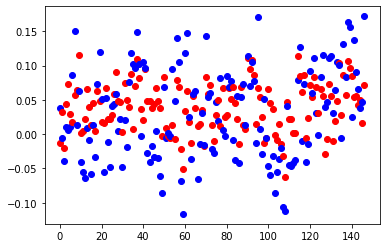

In [113]:
import matplotlib.pyplot as plt
print(len(list(result_hard.keys())))
print(len(list(result_gn.keys())))
key_list = list(result_hard.keys())
for x in range(len(key_list)):
  plt.scatter(x, result_hard[key_list[x]],c='red')
  plt.scatter(x, result_gn[key_list[x]],c='blue')
plt.savefig("/content/gdrive/MyDrive/result.png")


In [114]:
def average_cos(result):
  sum = 0
  for element in result:
    sum += result[element]
  average = sum / len(result)
  return average

print(average_cos(result))
print(average_cos(result_hard))
print(average_cos(result_gn))

0.04048196892066513
0.0393187439383838
0.030750115775586777
